In [843]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

import cv2
import matplotlib.pyplot as plt
import random
import cv2
import matplotlib.pyplot as plt
import random
import torch
import torch.optim as optim
import numpy as np


In [844]:
if os.path.exists('goat.jpg'):
    print('goat.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

goat.jpg exists


torch.Size([3, 1226, 1080])


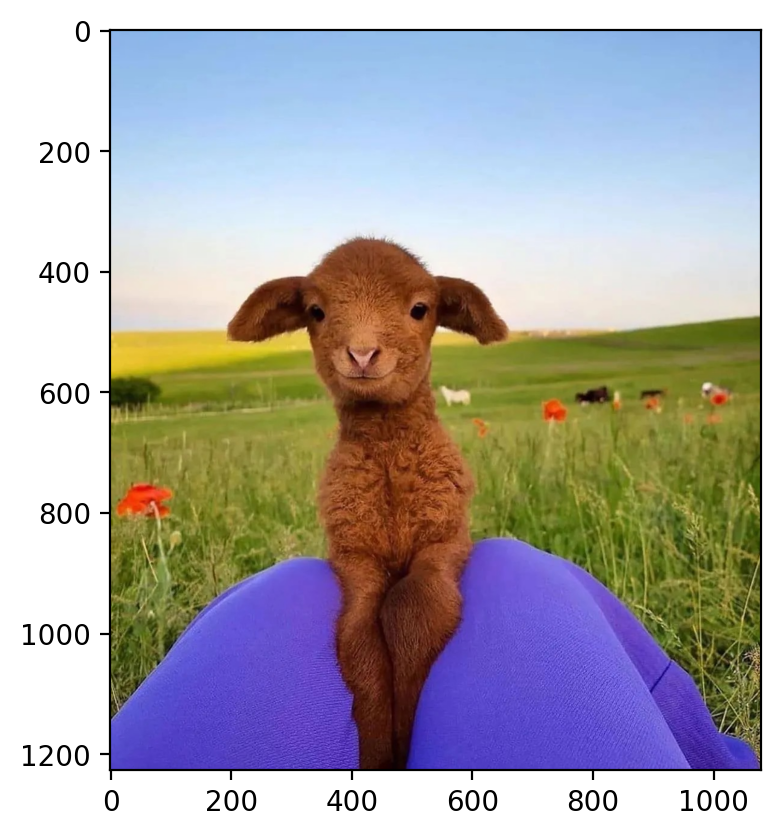

In [845]:
img = torchvision.io.read_image("goat.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [846]:
def read_image(image_path):
    image = cv2.imread('goat.jpg')
    if image is None:
        print("Error: Could not load image.")
        return None
    return image

In [847]:
def select_random_patch(image, patch_size=50):
    height, width, _ = image.shape
    x = 400
    y = 400
    return x, y


In [848]:
def extract_patch(image, x, y, patch_size=50):
    # Extract the patch from the image
    patch = image[y:y+patch_size, x:x+patch_size].copy()
    return patch


In [849]:
def display_patch_and_highlight(image, x, y, patch, patch_size=50):
    # Convert BGR to RGB for display using matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image and highlight the selected patch
    plt.figure(figsize=(10, 5))  # Adjust the figure size

    # Display the full image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Full Image with Highlighted Patch")

    # Draw rectangle to highlight the extracted patch
    rect_x = [x, x+patch_size, x+patch_size, x, x]
    rect_y = [y, y, y+patch_size, y+patch_size, y]
    plt.plot(rect_x, rect_y, color='#FF0000', linewidth=2)  # Red color for the rectangle
    plt.axis('on')  # Keep the axis visible

    # Display the extracted patch separately
    patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, 2)
    plt.imshow(patch_rgb)
    plt.title("Extracted Patch")
    plt.axis('off')  # Remove the axis for better visualization

    # Show the images side by side
    plt.tight_layout()
    plt.show()


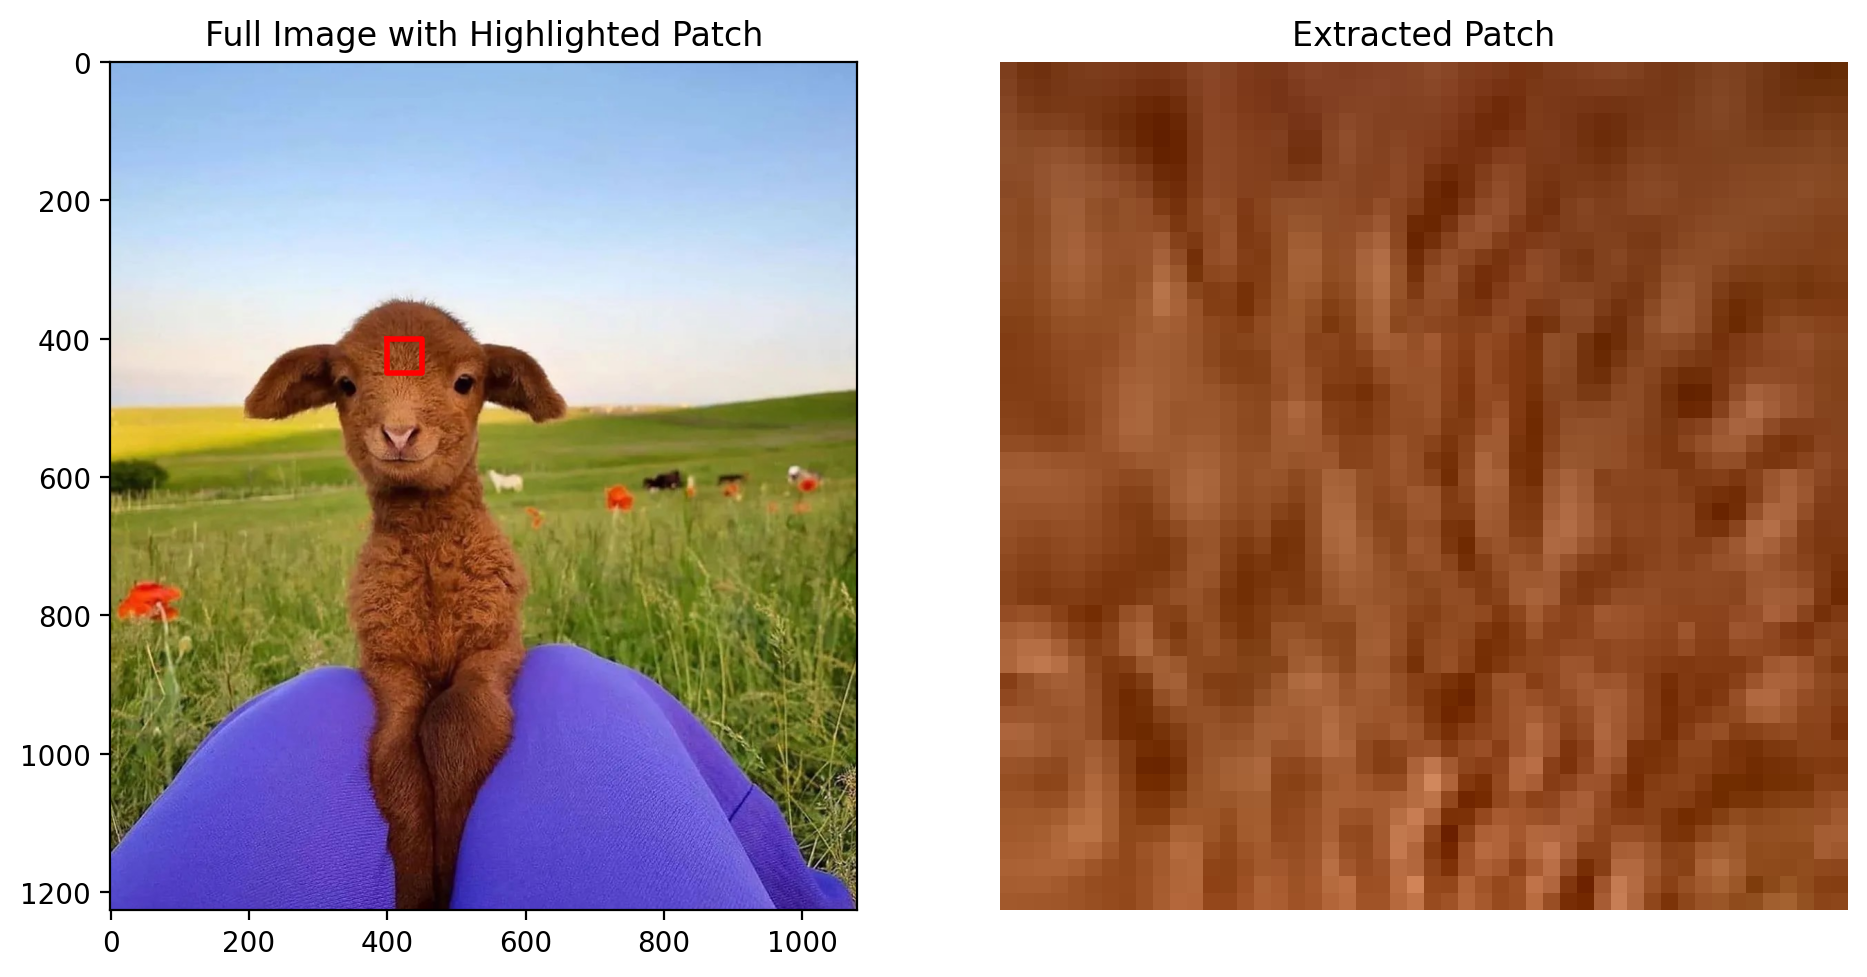

In [850]:

# Load the image and extract a patch
image = cv2.imread('goat.jpg')  # Load your image
x, y = select_random_patch(image, patch_size=50)  # Get coordinates
patch = extract_patch(image, x, y, patch_size=50)  # Extract the patch

display_patch_and_highlight(image, x, y, patch, patch_size=50)


In [851]:
#masking the patch by creating a copy of it 
def mask_patch(image, patch, x, y):
    masked_image = image.copy()
    masked_image[y:y+patch.shape[0], x:x+patch.shape[1]] = patch
    return masked_image

In [852]:
# Matrix Factorization 
def factorize(A, r, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss


In [853]:
#for all channels 
def reconstruct_patch(original_patch, r):
    patch_tensor = torch.tensor(original_patch, dtype=torch.float).permute(2, 0, 1)
    for i in range(3):  # For each color channel
        W, H, loss = factorize(patch_tensor[i], r)
        patch_tensor[i] = torch.mm(W, H).detach()
    return np.clip(patch_tensor.permute(1, 2, 0).numpy(), 0, 255).astype('uint8')


In [854]:
# computing the rmse and psnr 
def compute_rmse(original, reconstructed):
    diff = original - reconstructed
    rmse = np.sqrt(np.mean(diff ** 2))
    return rmse


def compute_psnr(original_patch, reconstructed_patch):
    original_patch = original_patch.astype(np.float32)
    reconstructed_patch = reconstructed_patch.astype(np.float32)
    mse = np.mean((original_patch - reconstructed_patch) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


In [855]:
# function for displaying and comparing the patches for all ranks 
def display_comparison(original_patch, reconstructed_patch):
    plt.figure(figsize=(8, 4))  # Increased width for more space between images

    # Display the original patch
    plt.subplot(1, 2, 1)
    plt.imshow(original_patch)
    plt.title("Original 50x50 Patch", fontsize=12)  # Reduced title font size
    plt.axis('on')  # Keep axis visible

    # Display the reconstructed patch
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_patch)
    plt.title("Reconstructed 50x50 Patch", fontsize=12)  # Reduced title font size
    plt.axis('on')  # Keep axis visible

    plt.subplots_adjust(wspace=0.5)  # Adjust space between the two subplots
    plt.show()


In [856]:
# function to process the patch using matrix factorization and display it
def process_image(image_path, patch_size=50, ranks=[5, 10, 25, 50]):
    image = read_image(image_path)
    if image is None:
        return

    x, y = select_random_patch(image, patch_size)
    original_patch = extract_patch(image, x, y, patch_size)
    rmse_values = []
    psnr_values = []

    for r in ranks:
        # Reconstruct the patch using the current rank
        reconstructed_patch = reconstruct_patch(original_patch, r)

        # Convert original and reconstructed patches to RGB for display
        original_patch_rgb = cv2.cvtColor(original_patch, cv2.COLOR_BGR2RGB)
        reconstructed_patch_rgb = cv2.cvtColor(reconstructed_patch, cv2.COLOR_BGR2RGB)

        # Create a masked image with the reconstructed patch
        masked_image = image.copy()
        masked_image[y:y+patch_size, x:x+patch_size] = reconstructed_patch

        # Display the results
        display_comparison(original_patch_rgb, reconstructed_patch_rgb)

        # Compute RMSE and PSNR
        rmse = compute_rmse(original_patch, reconstructed_patch)
        psnr = compute_psnr(original_patch, reconstructed_patch)
        rmse_values.append(rmse)
        psnr_values.append(psnr)

        print(f"Rank: {r} -> RMSE: {rmse:.2f}, PSNR: {psnr:.2f} dB")

    # Plot RMSE and PSNR
    plot_rmse_psnr(ranks, rmse_values, psnr_values)




In [857]:
# plotting the rmse and psnr as a function of rank of the matrices
def plot_rmse_psnr(ranks, rmse_values, psnr_values):
    plt.figure(figsize=(10, 5))

    # Plot RMSE
    plt.subplot(1, 2, 1)
    plt.plot(ranks, rmse_values, marker='o', linestyle='-', color='b')
    plt.title('Rank vs RMSE')
    plt.xlabel('Rank')
    plt.ylabel('RMSE')
    plt.xticks(ranks)
    plt.grid(True)

    # Plot PSNR
    plt.subplot(1, 2, 2)
    plt.plot(ranks, psnr_values, marker='o', linestyle='-', color='r')
    plt.title('Rank vs PSNR')
    plt.xlabel('Rank')
    plt.ylabel('PSNR (dB)')
    plt.xticks(ranks)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


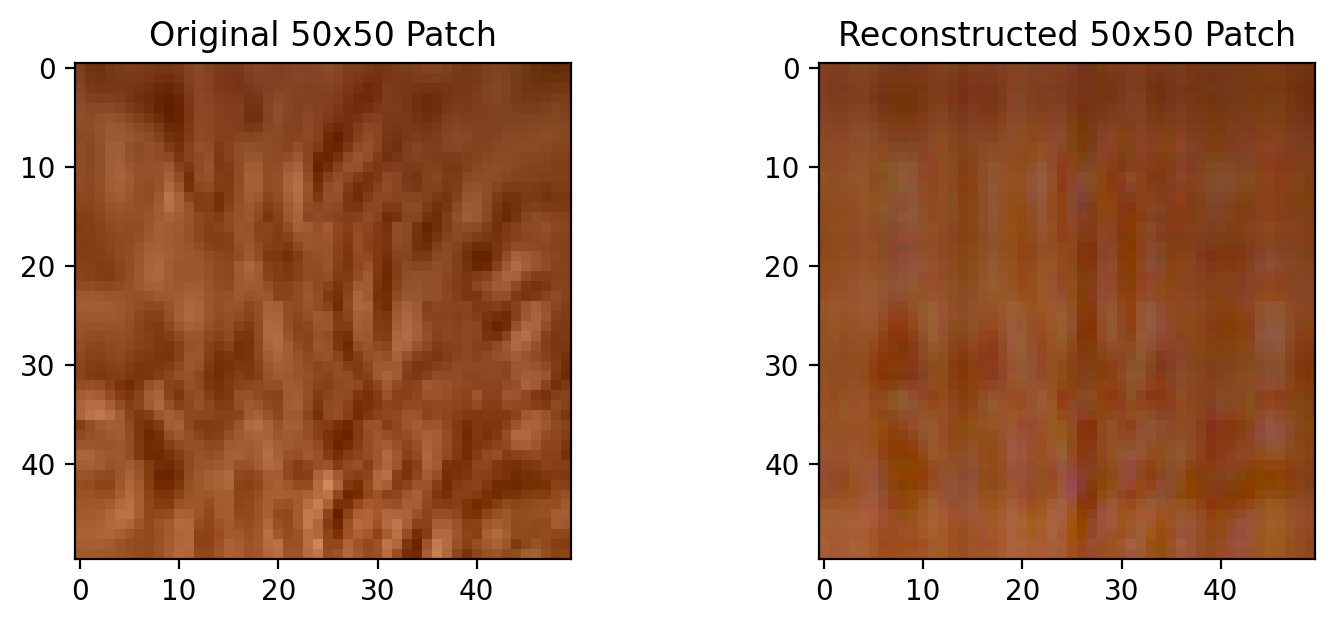

Rank: 5 -> RMSE: 7.88, PSNR: 27.41 dB


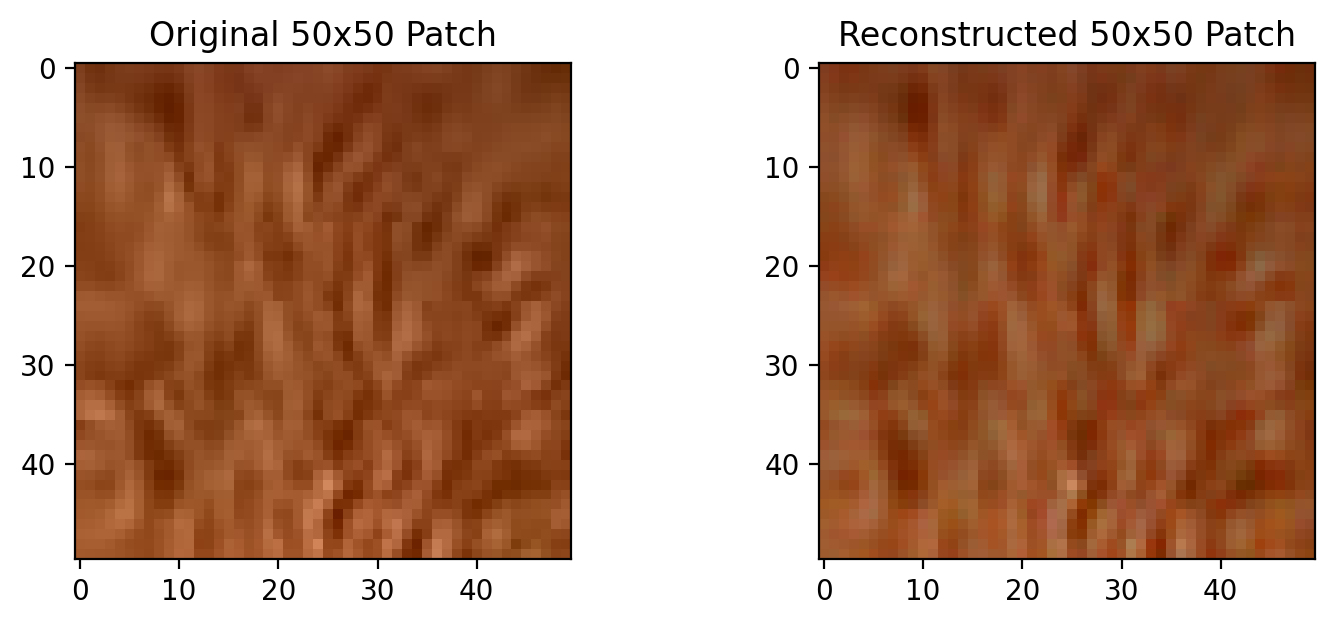

Rank: 10 -> RMSE: 5.59, PSNR: 31.81 dB


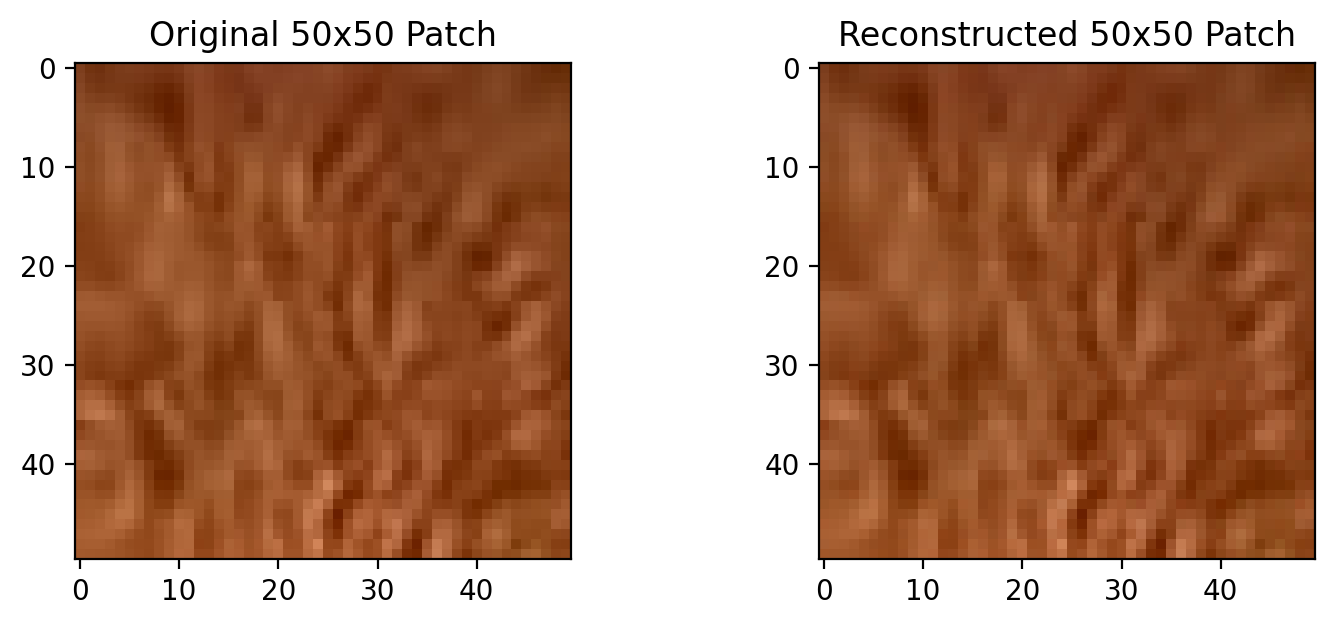

Rank: 25 -> RMSE: 1.11, PSNR: 47.22 dB


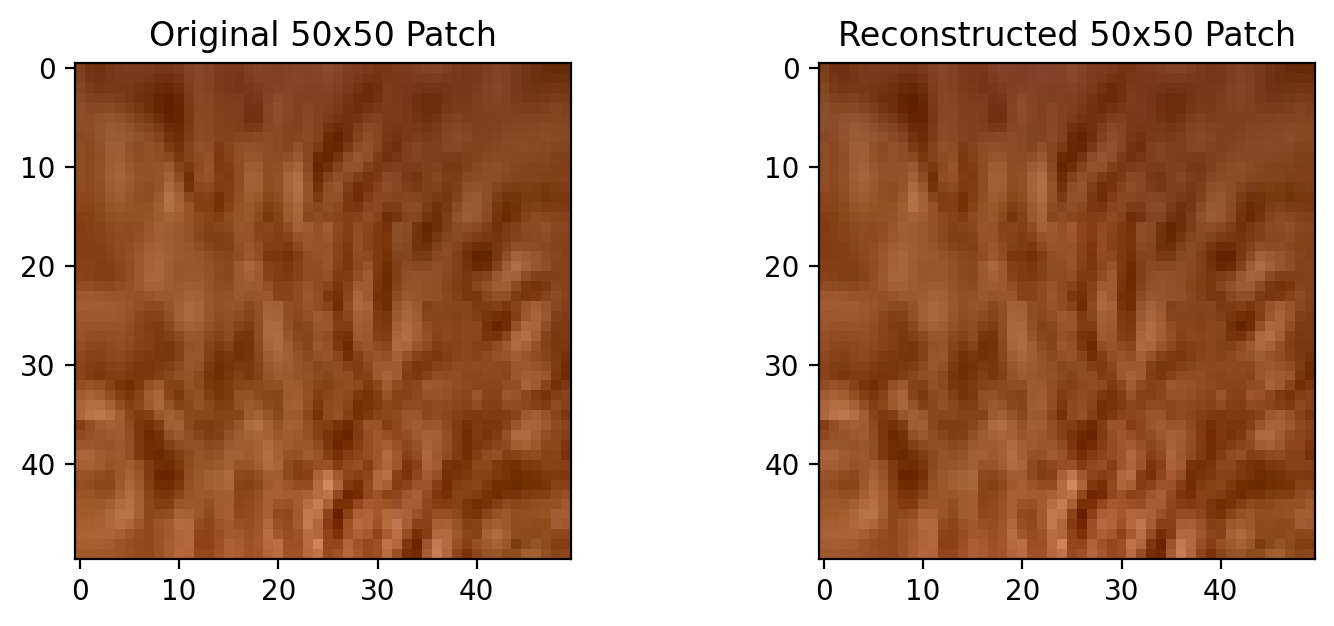

Rank: 50 -> RMSE: 0.79, PSNR: 50.14 dB


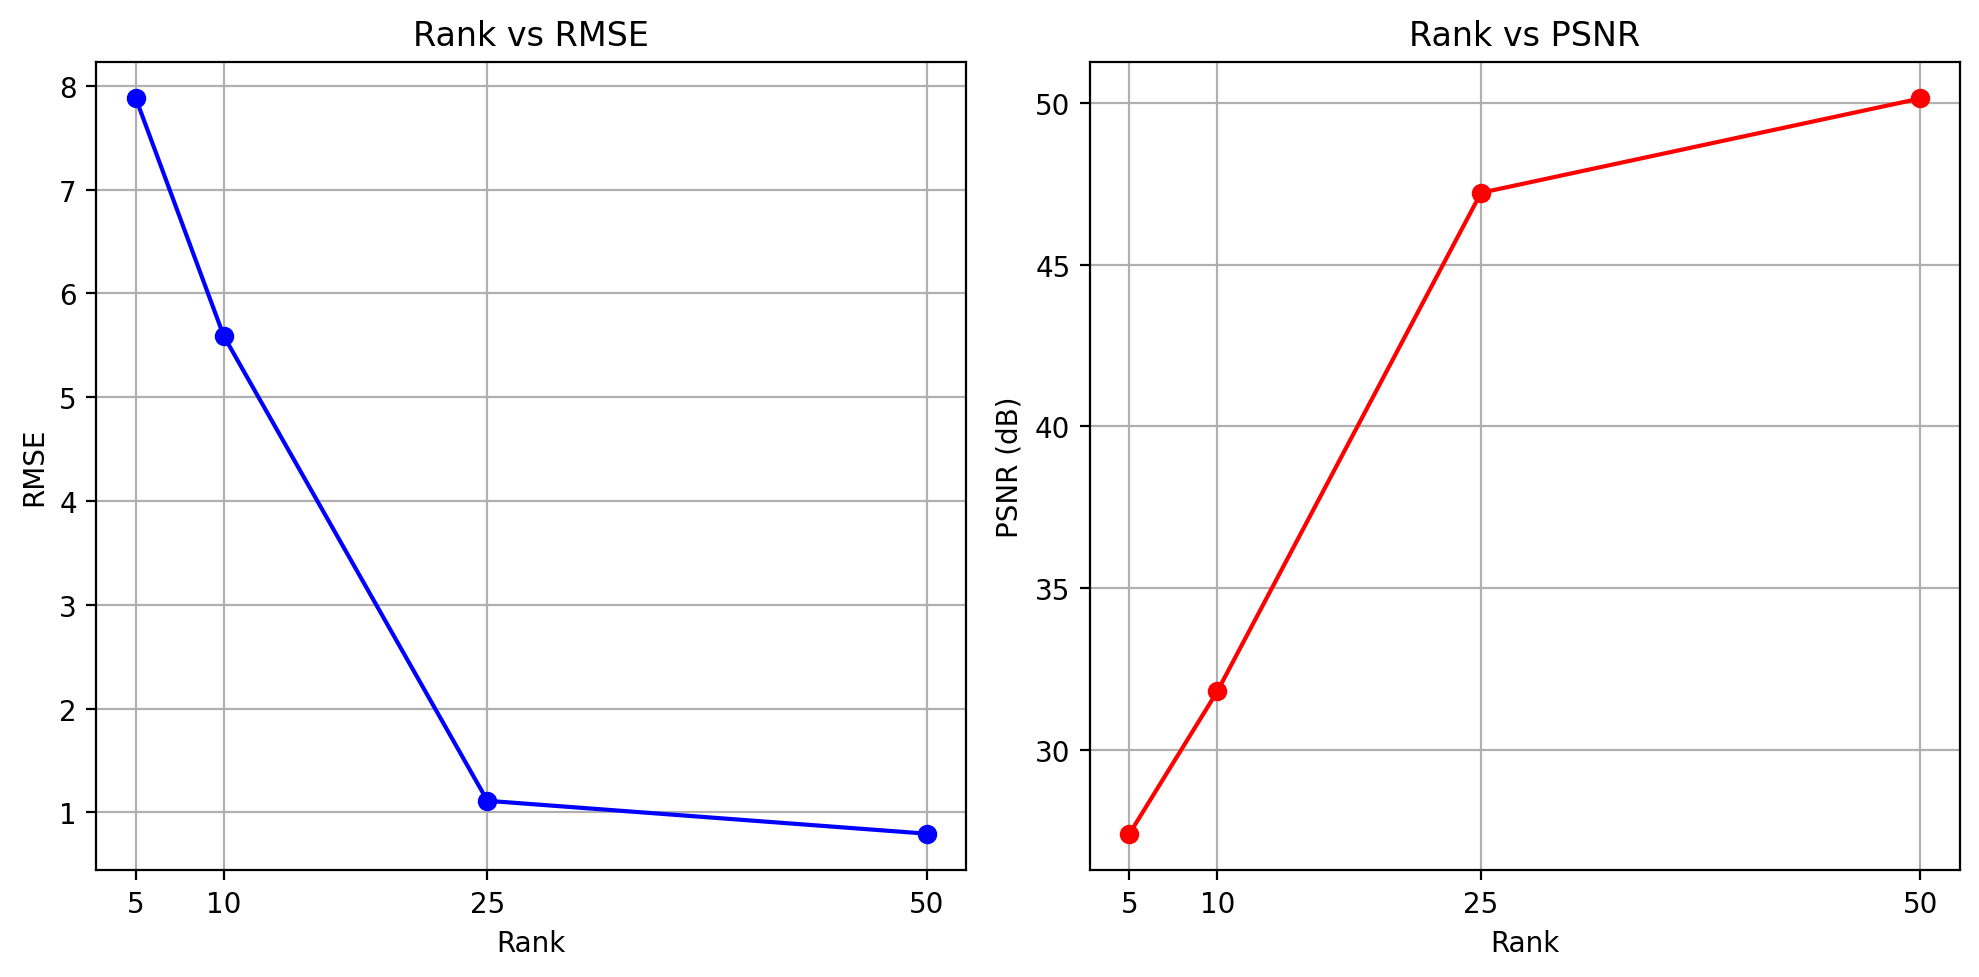

In [858]:
process_image('goat.jpg', patch_size=50, ranks=[5, 10, 25, 50])

Rank: 5 -> RMSE: 7.78
Rank: 10 -> RMSE: 5.64
Rank: 25 -> RMSE: 1.11
Rank: 50 -> RMSE: 0.93


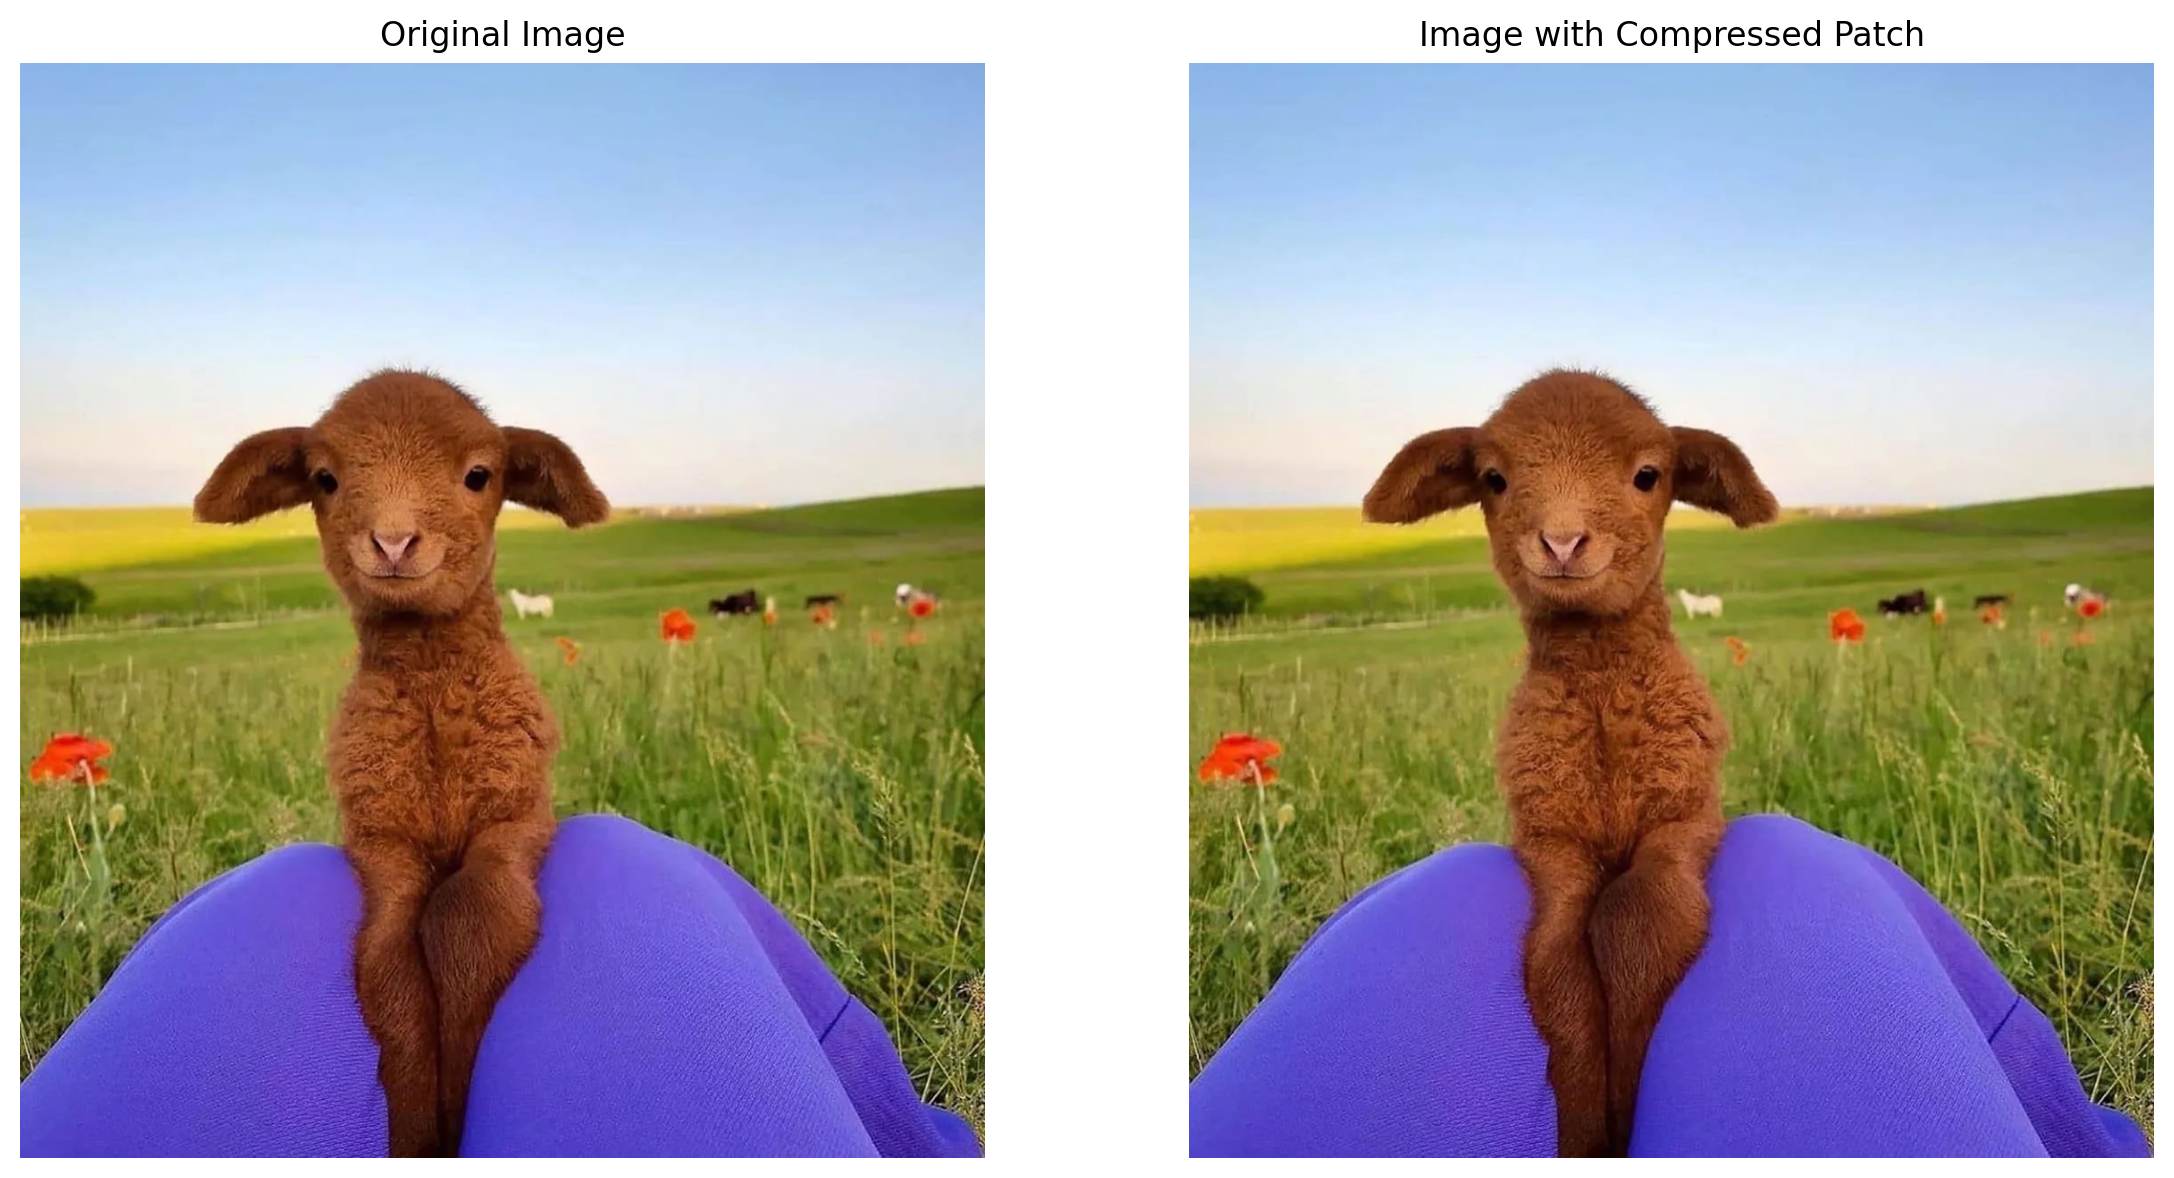

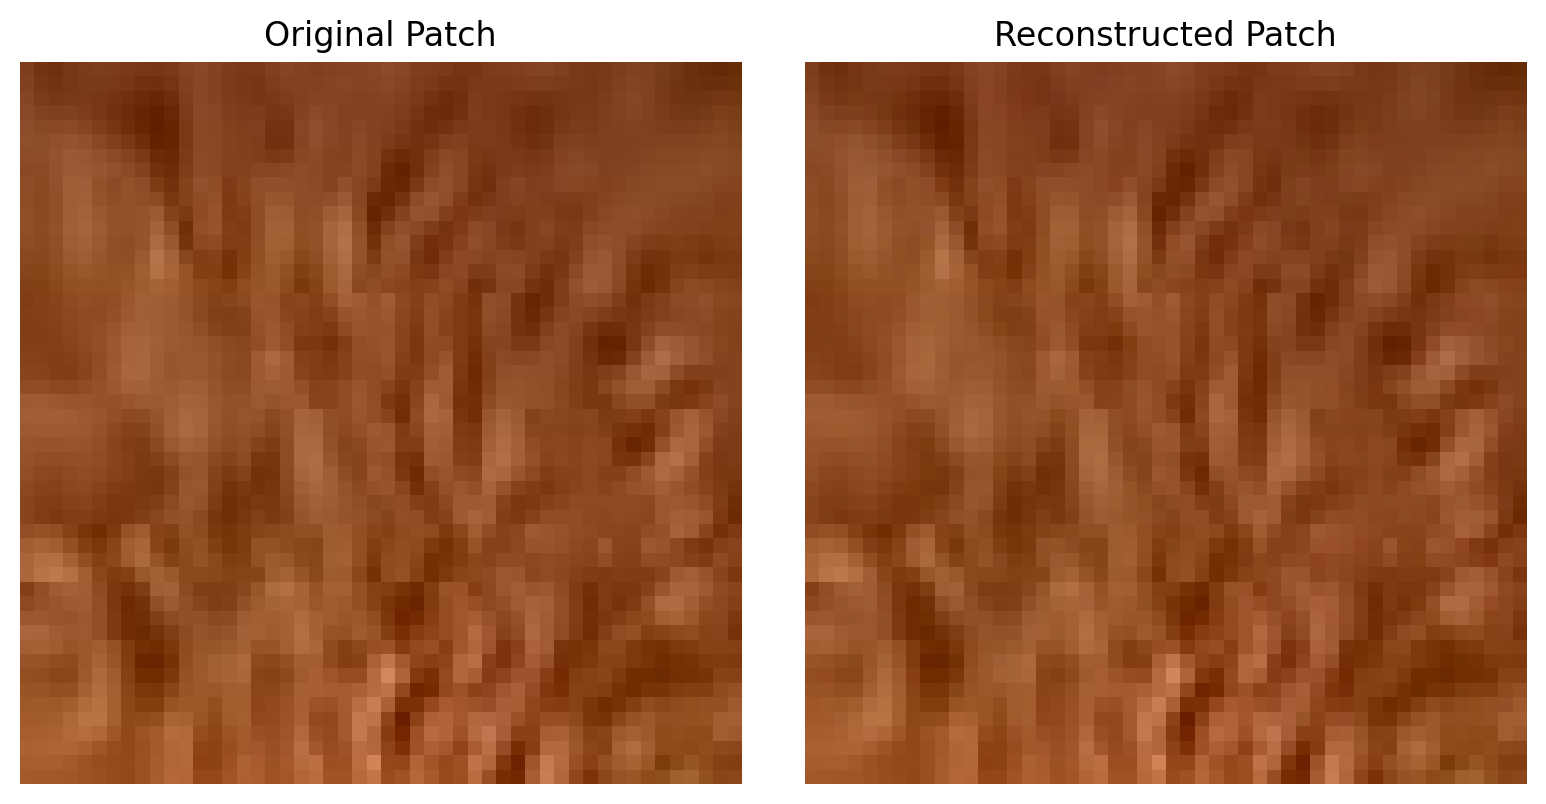

In [859]:
 # redefining the same functions to display the compressed patch in the original image and comaparing it with the original image
# replacing the best compressed patch with minimum rmse error in the original image 

# updated process_image function
def process_image(image_path, patch_size=50, ranks=[5, 10, 25, 50]):
    image = read_image(image_path)  # Use image_path argument
    if image is None:
        return

    x, y = select_random_patch(image, patch_size)
    original_patch = extract_patch(image, x, y, patch_size)

    best_rmse = float('inf')
    best_masked_image = None

    for r in ranks:
        # Reconstruct the patch using the current rank
        reconstructed_patch = reconstruct_patch(original_patch, r)

        # Create a masked image with the reconstructed patch
        masked_image = image.copy()
        masked_image[y:y+patch_size, x:x+patch_size] = reconstructed_patch

        # Compute RMSE and PSNR
        rmse = compute_rmse(original_patch, reconstructed_patch)

        if rmse < best_rmse:
            best_rmse = rmse
            best_masked_image = masked_image

        print(f"Rank: {r} -> RMSE: {rmse:.2f}")

    return image, best_masked_image, original_patch, reconstructed_patch

# updated display fuction
def display_comparison(original_image, masked_image, original_patch, reconstructed_patch):
    plt.figure(figsize=(12, 6))

    # Display the original image with the reconstructed patch
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image", fontsize=12)
    plt.axis('off')

    # Display the masked image with the compressed patch
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.title("Image with Compressed Patch", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Display the original and reconstructed patches
    plt.figure(figsize=(8, 4))

    # Original patch
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_patch, cv2.COLOR_BGR2RGB))
    plt.title("Original Patch", fontsize=12)
    plt.axis('off')

    # Reconstructed patch
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(reconstructed_patch, cv2.COLOR_BGR2RGB))
    plt.title("Reconstructed Patch", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = 'goat.jpg'
original_image, best_masked_image, original_patch, reconstructed_patch = process_image(image_path, patch_size=50, ranks=[5, 10, 25, 50])
display_comparison(original_image, best_masked_image, original_patch, reconstructed_patch)


In [860]:
# def process_image(image_path, patch_size=50, ranks=[5, 10, 25, 50]):
#     image = read_image(image_path)
#     if image is None:
#         return

#     x, y = select_random_patch(image, patch_size)
#     original_patch = extract_patch(image, x, y, patch_size)

#     for r in ranks:
#         # Reconstruct the patch using the current rank
#         reconstructed_patch = reconstruct_patch(original_patch, r)

#         # Convert original and reconstructed patches to RGB for display
#         original_patch_rgb = cv2.cvtColor(original_patch, cv2.COLOR_BGR2RGB)
#         reconstructed_patch_rgb = cv2.cvtColor(reconstructed_patch, cv2.COLOR_BGR2RGB)

#         # Create a masked image with the reconstructed patch
#         masked_image = image.copy()
#         masked_image[y:y+patch_size, x:x+patch_size] = reconstructed_patch

#         # Display the results
#         display_comparison(original_patch_rgb, reconstructed_patch_rgb, masked_image)
        
#         # Compute RMSE and PSNR
#         rmse = compute_rmse(original_patch, reconstructed_patch)
#         psnr = compute_psnr(original_patch, reconstructed_patch)

#         print(f"Rank: {r} -> RMSE: {rmse:.2f}, PSNR: {psnr:.2f} dB")


In [861]:
# def display_comparison(original_patch, reconstructed_patch, masked_image):
#     plt.figure(figsize=(12, 4))  # Increased width for more space between images

#     # Display the original patch
#     plt.subplot(1, 3, 1)
#     plt.imshow(original_patch)
#     plt.title("Original 50x50 Patch", fontsize=12)
#     plt.axis('on')

#     # Display the reconstructed patch
#     plt.subplot(1, 3, 2)
#     plt.imshow(reconstructed_patch)
#     plt.title("Reconstructed 50x50 Patch", fontsize=12)
#     plt.axis('on')

#     # Display the full image with the reconstructed patch
#     plt.subplot(1, 3, 3)
#     masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
#     plt.imshow(masked_image_rgb)
#     plt.title("Full Image with Reconstructed Patch", fontsize=12)
#     plt.axis('off')

#     plt.subplots_adjust(wspace=0.5)
#     plt.show()


In [862]:
# process_image('goat.jpg', patch_size=50, ranks=[5, 10, 25, 50])